In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, ensemble
import pandas as pd
from netCDF4 import Dataset as netcdf


In [2]:
fn = '/disk2/yhy/Research/ECP/SCM/IOP/TOGA_COARE_6hr_scm.nc'
fid = netcdf(fn, 'r')
tb = {'ps':fid.variables['Ps'][:,0,0]/100.0, 'ts':fid.variables['Tsair'][:,0,0]-273.15, 
      'prec':fid.variables['Prec'][:,0,0]*86400*1000.0, 'qs':fid.variables['qsrf'][:,0,0]*1000, 
      'us':fid.variables['usrf'][:,0,0], 'vs':fid.variables['vsrf'][:,0,0], 
      'lhf':fid.variables['lhflx'][:,0,0], 'shf':fid.variables['shflx'][:,0,0], 
      'winds':fid.variables['windsrf'][:,0,0] }
tb = pd.DataFrame(tb)
tb.tail(5)

,lhf,prec,ps,qs,shf,ts,us,vs,winds
473,114.784309,4.577092,1009.299988,18.017637,5.402504,27.658173,-2.852884,4.950519,5.713719
474,114.597557,3.193980,1007.599976,18.019382,3.645755,27.785156,-0.975678,4.201619,4.313415
475,134.227768,2.880946,1010.200012,18.019543,1.303744,28.924011,0.500634,3.979665,4.011031
476,92.256454,2.591730,1007.000000,18.019543,2.027909,28.585297,0.986552,2.811571,2.979634
477,75.354523,1.524179,1010.000000,18.007843,2.915285,27.810669,1.066752,1.912421,2.189820


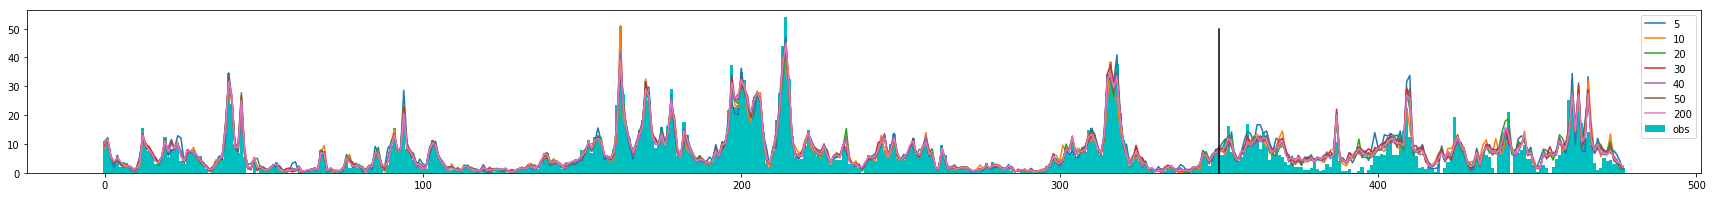

In [36]:
# random forest regression

vars = ['ts', 'ps', 'shf', 'lhf', 'winds', 'us', 'vs', 'qs']
nsplit = 5
ntree = [5, 10, 20, 30, 40, 50, 200]
mse = [np.NaN for i in ntree]
ntrain = 350

plt.figure(1, figsize=(30,3))
plt.bar(range(len(tb)), tb['prec'], color='c', width=1)

for i in range(len(ntree)):
    rf = ensemble.RandomForestRegressor( n_estimators=ntree[i], criterion='mse', 
       max_depth=None, min_samples_split=2, min_samples_leaf=1, 
       min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, 
       min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, 
       oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

    rf.fit(tb.loc[:ntrain, vars], tb.loc[:ntrain,'prec'])
    ypred = rf.predict(tb[vars])
    mse[i] = np.mean((ypred[ntrain:]-tb.loc[ntrain:, 'prec'])**2) 
    plt.plot(ypred)

plt.legend( ntree + ['obs'], loc='best' )
plt.plot([ntrain, ntrain], [0, 50], 'k-')
plt.show()



In [23]:
pd.DataFrame({'N_Tree':ntree, 'Score_MSE':mse})


,N_Tree,Score_MSE
0,5,26.643143
1,10,17.554011
2,20,19.989699
3,30,19.153024
4,40,17.548312
5,50,18.002222
6,200,17.254522


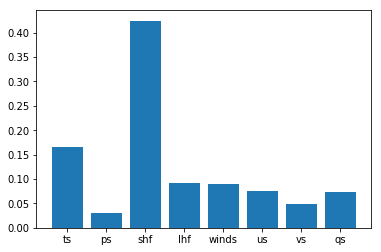

In [37]:
plt.bar( range(len(vars)), rf.feature_importances_ )
plt.xticks( range(len(vars)), vars )
plt.show()


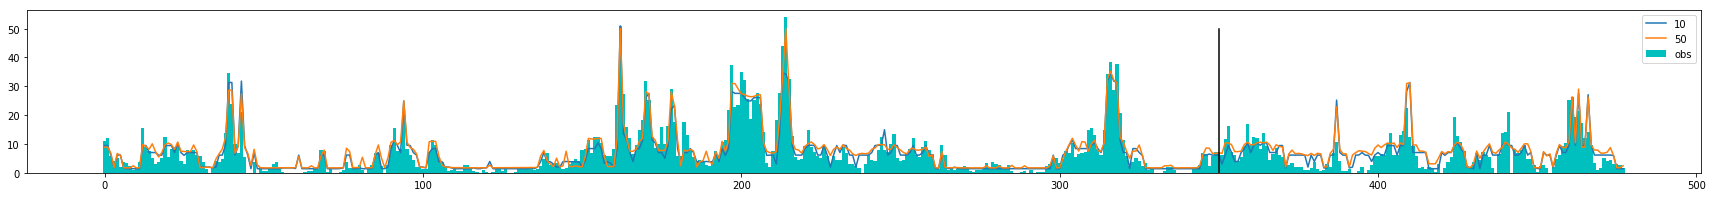

In [46]:
# Adaboost regressor

vars = ['ts', 'ps', 'shf', 'lhf', 'winds', 'us', 'vs', 'qs']
nsplit = 5
#ntree = [10, 50, 100, 200]
ntree = [10, 50]
mse = []

plt.figure(1, figsize=(30,3))
plt.bar(range(len(tb)), tb['prec'], color='c', width=1)

for i in range(len(ntree)):
    rf = ensemble.AdaBoostRegressor( n_estimators=ntree[i], 
                    learning_rate=0.1, loss='square', random_state=None)

    rf.fit(tb.loc[:ntrain, vars], tb.loc[:ntrain, 'prec'])
    ypred = rf.predict(tb[vars])
    mse.append( np.mean((ypred[ntrain:]-tb.loc[ntrain:, 'prec'])**2) )


    plt.plot(ypred)

plt.legend( ntree + ['obs'], loc='best' )
plt.plot([ntrain, ntrain], [0, 50], 'k-')

plt.show()

In [47]:
pd.DataFrame({'N_estimator':ntree, 'Score_MSE':mse})


,N_estimator,Score_MSE
0,10,21.481746
1,50,23.428685


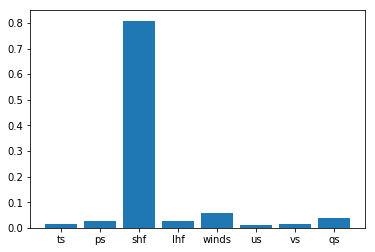

In [48]:
plt.bar( range(len(vars)), rf.feature_importances_ )
plt.xticks( range(len(vars)), vars )
plt.show()


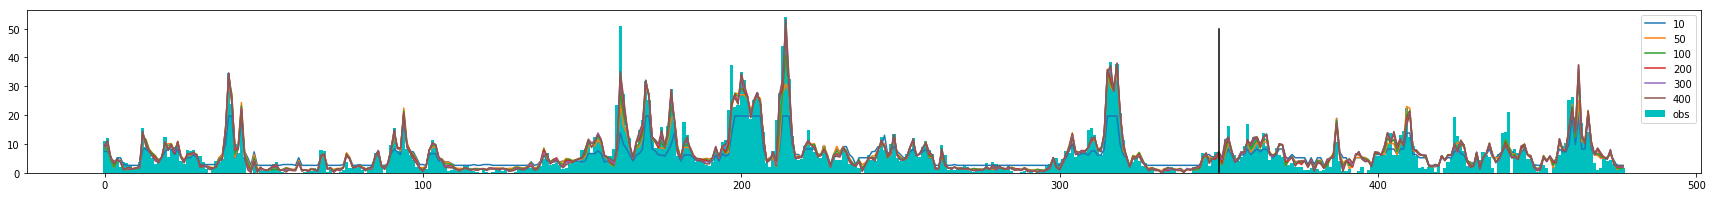

In [34]:
# Gradient boosting regressor

vars = ['ts', 'ps', 'shf', 'lhf', 'winds', 'us', 'vs', 'qs']
nsplit = 5
ntree = [10, 50, 100, 200, 300, 400]
mse = []

plt.figure(1, figsize=(30,3))
plt.bar(range(len(tb)), tb['prec'], color='c', width=1)

for i in range(len(ntree)):
    rf = ensemble.GradientBoostingRegressor( loss='huber', learning_rate=0.1, n_estimators=ntree[i], 
            subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
            min_weight_fraction_leaf=0.0, max_depth=2, min_impurity_decrease=0.0, 
            min_impurity_split=None, init=None, random_state=None, max_features=None, 
            alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto' )

    rf.fit(tb.loc[:ntrain,vars], tb.loc[:ntrain, 'prec'])
    ypred = rf.predict(tb[vars])
    mse.append(  np.mean((ypred[ntrain:]-tb.loc[ntrain:, 'prec'])**2) ) 


    plt.plot(ypred)

plt.legend( ntree + ['obs'], loc='best' )
plt.plot([ntrain, ntrain], [0, 50], 'k-')

plt.show()

In [35]:
pd.DataFrame({'N_estimator':ntree, 'Score_MSE':mse})


,N_estimator,Score_MSE
0,10,16.342521
1,50,12.255123
2,100,12.811418
3,200,14.022738
4,300,14.811615
5,400,14.751317
